In [1]:
import pandas as pd

In [2]:
ecapa_results = '../data/lid-vox-lingua107-ecapa-results'

In [10]:
df = pd.read_csv(ecapa_results+'.csv')
df.head()

,label,pred,pred_score,eng_score,acc
0,tic,sl,0.2963,0.0002,1
1,tic,no,0.2148,0.0166,1
2,tic,sw,0.2069,0.0011,1
3,tic,so,0.3580,0.0045,1
4,tic,sl,0.3263,0.0001,1


In [15]:
tic = df['label']=='tic'
eng = df['label']=='eng'

<Axes: title={'center': 'eng_score'}, xlabel='label'>

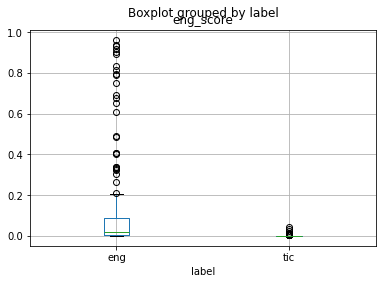

In [14]:
df.boxplot('eng_score', by='label')

In [18]:
eng_thresh = df.loc[tic, 'eng_score'].max()
eng_thresh

0.0433

In [24]:
eng_thresh = 0.01

In [25]:
above_thresh = df['eng_score'] > eng_thresh
df.loc[above_thresh, 'label'].value_counts()

eng    131
tic      7
Name: label, dtype: int64

In [26]:
df.loc[~above_thresh, 'label'].value_counts()

tic    193
eng     69
Name: label, dtype: int64

In [1]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import v_measure_score, homogeneity_score, completeness_score
import torch
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../data/lid-vox-lingua107-ecapa-embeds-3cat.csv')
df.head()

,Unnamed: 0,lang,audio
0,0,HIM,Audacity Recording 181[1535200.0-1537500.0].wav
1,1,HIM,Audacity Recording 181[1547800.0-1550000.0].wav
2,2,HIM,Audacity Recording 181[1562655.0-1565685.0].wav
3,3,HIM,Audacity Recording 181[1578900.0-1580300.0].wav
4,4,HIM,Audacity Recording 181[1580600.0-1582500.0].wav


In [3]:
tic = df['lang']=='TIC'
eng = df['lang']=='ENG'
him = df['lang']=='HIM'
df['y']=0
df.loc[tic,'y']=1
df['y'].value_counts()

0    400
1    200
Name: y, dtype: int64

In [4]:
df['y1']=df['y']
df.loc[him, 'y1']=2
df['y1'].value_counts()

2    200
0    200
1    200
Name: y1, dtype: int64

In [5]:
embeds = torch.load('../data/lid-vox-lingua107-ecapa-embeds-3cat.pt', map_location=torch.device('cpu'))
embeds = embeds.squeeze()
embeds.shape

torch.Size([600, 256])

In [6]:
sid_embeds = torch.load('../data/spkrec-ecapa-voxceleb.pt', map_location=torch.device('cpu'))
sid_embeds = sid_embeds.squeeze()
sid_embeds.shape

torch.Size([600, 192])

In [28]:
cl_embeds = torch.load('../data/lang-id-commonlanguage_ecapa.pt', map_location=torch.device('cpu'))
cl_embeds = cl_embeds.squeeze()
cl_embeds.shape

torch.Size([600, 192])

In [121]:
logits, hs = torch.load('../data/mms-lid-126-embed.pt', map_location=torch.device('cpu'))
logits.shape, len(hs)

(torch.Size([600, 126]), 38)

In [123]:
hs_unsqueezed = []
for batch in hs:
    hs_unsqueezed+=batch
len(hs_unsqueezed)

600

In [124]:
hs = hs_unsqueezed

In [129]:
def avg_hs_by_layer(hs_list):
    hs_means_by_layer = []
    num_layers = len(hs_list[0])
    for layer_idx in range(num_layers):
        layer_means = [
            torch.mean(ex[layer_idx], 0) for ex in hs_list
        ]
        hs_means_by_layer.append(torch.stack(layer_means))
    return hs_means_by_layer
hs_means_by_layer = avg_hs_by_layer(hs)
hs_avgs = hs_means_by_layer

In [29]:
df_nohimeng = df[~him]
embeds_nohimeng = embeds[~him]
sid_nohimeng = sid_embeds[~him]
cl_nohimeng = cl_embeds[~him]
# logits_nohimeng = logits[~him]
# hs_nohimeng = [record_hs for i, record_hs in enumerate(hs) if him[i]==0]
# hs_avgs_nohimeng = [layer[~him] for layer in hs_means_by_layer]
df_nohimeng.shape, embeds_nohimeng.shape, #logits_nohimeng.shape, len(hs_nohimeng), hs_avgs_nohimeng[0].shape

((400, 6), torch.Size([400, 256]))

In [31]:
df_noeng = df[~eng]
embeds_noeng = embeds[~eng]
sid_noeng = sid_embeds[~eng]
cl_noeng = cl_embeds[~eng]
# logits_noeng = logits[~eng]
# hs_noeng = [record_hs for i, record_hs in enumerate(hs) if eng[i]==0]
# hs_avgs_noeng = [layer[~eng] for layer in hs_means_by_layer]
df_noeng.shape, embeds_noeng.shape, #logits_noeng.shape, len(hs_noeng), hs_avgs_noeng[0].shape

((400, 6), torch.Size([400, 256]))

In [32]:
df_notic = df[~tic]
embeds_notic = embeds[~tic]
sid_notic = sid_embeds[~tic]
cl_notic = cl_embeds[~tic]
# logits_notic = logits[~tic]
# hs_notic = [record_hs for i, record_hs in enumerate(hs) if tic[i]==0]
# hs_avgs_notic = [layer[~tic] for layer in hs_means_by_layer]
df_notic.shape, embeds_notic.shape#, logits_notic.shape, len(hs_notic), hs_avgs_notic[0].shape

((400, 6), torch.Size([400, 256]))

In [7]:
pca = PCA(n_components=2)
pca

PCA(n_components=2)

In [60]:
pca_embeds = pca.fit_transform(embeds)
pca_embeds

array([[  10.20631384,  -91.79226152],
       [  -4.92665541,  -78.0248183 ],
       [ -11.70571516,  -68.89355753],
       ...,
       [ -45.29064516,  -93.24683871],
       [-109.37196049,   20.75016816],
       [ -71.11961724,  -51.98441365]])

In [8]:
pca_sid = pca.fit_transform(sid_embeds)
pca_sid

array([[  66.43823739,  -52.74030027],
       [-108.11748204,   30.89717103],
       [-111.22697391,  -13.00838018],
       ...,
       [ -94.87086877, -101.93180085],
       [-146.74215955,  -14.0381393 ],
       [-171.1717427 ,  -83.99380167]])

In [33]:
pca_cl = pca.fit_transform(cl_embeds)
pca_cl

array([[ -7.29125802, -13.70979921],
       [ -7.28738767,  10.10733864],
       [-12.04611981,   7.51937965],
       ...,
       [-34.04729656, -43.03866252],
       [-31.08244595, -35.32416734],
       [-31.62234573, -21.69588647]])

In [62]:
pca_logits = pca.fit_transform(logits)
pca_logits

array([[ 9.07738449, -7.85256978],
       [-1.84973964, -8.54190023],
       [-3.57622623, -5.65473779],
       ...,
       [ 6.23053076,  5.66389456],
       [14.11748685,  6.20166631],
       [13.24897975, -6.01171397]])

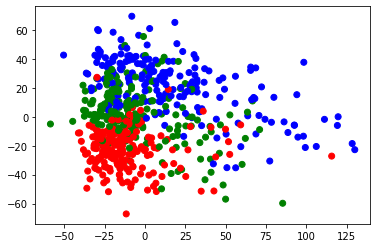

In [34]:
df['color'] = 'blue'
df.loc[df['lang']=='TIC','color'] = 'red'
df.loc[df['lang']=='HIM','color'] = 'green'

# x = pca_embeds[:,0]
# y = pca_embeds[:,1]
x = pca_cl[:,0]
y = pca_cl[:,1]
c = df['color']
plt.scatter(x, y, c=c)

In [10]:
kmeans = KMeans(2)
kmeans

KMeans(n_clusters=2)

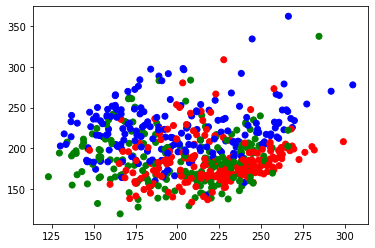

In [13]:
embeds_kmeans = kmeans.fit_transform(embeds)
x = embeds_kmeans[:,0]
y = embeds_kmeans[:,1]
plt.scatter(x, y, c=c)

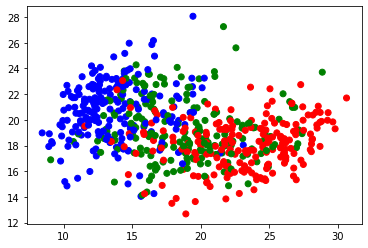

In [65]:
logits_kmeans = kmeans.fit_transform(logits)
x = logits_kmeans[:,0]
y = logits_kmeans[:,1]
plt.scatter(x, y, c=c)

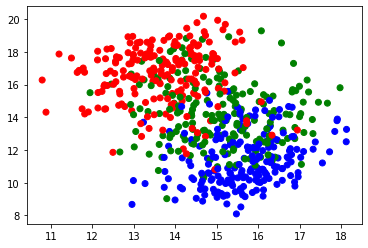

In [66]:
final_hs_kmeans = kmeans.fit_transform(final_hs_means)
x = final_hs_kmeans[:,0]
y = final_hs_kmeans[:,1]
plt.scatter(x, y, c=c)

In [81]:
def eval_kmeans(x, y, n_clusters=2, beta=1):
    labels = KMeans(n_clusters=n_clusters).fit(x).labels_
    scores = {
        'v_score': v_measure_score(y, labels, beta=beta),
        'completeness': completeness_score(y, labels),
        'homogeneity': homogeneity_score(y, labels),
    }
    return scores
eval_kmeans(cl_nohimeng,df_nohimeng['y1'],2)

{'v_score': 0.15368040527249524,
 'completeness': 0.1740007470552045,
 'homogeneity': 0.13760989857084138}

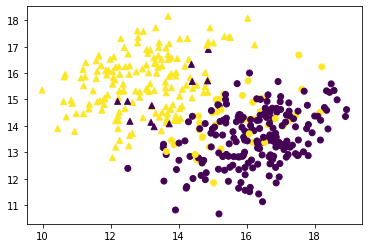

In [225]:
def plot_kmeans(x, y, n_clusters=2):
    clusters = KMeans(n_clusters=n_clusters).fit(x)
    labels = clusters.labels_
    points=clusters.transform(x)
    dim1=points[:,0]
    dim2=points[:,1]

    markers = ["^" , "o", "x"]
    for i, val in enumerate(np.unique(labels)):
        slice=labels==val
        plt.scatter(x=dim1[slice], y=dim2[slice], c=y[slice], marker=markers[i])
plot_kmeans(hs_avgs_noeng[-1],df_noeng['y1'],2)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(logits,df['y'], test_size=0.1)

In [50]:
x_train, x_test, y_train, y_test = train_test_split(embeds,df['y'], test_size=0.99)

In [45]:
lr = LogisticRegression()
lr

LogisticRegression()

In [51]:
lr=lr.fit(x_train, y_train)
lr

LogisticRegression()

In [52]:
y_hat=lr.predict(x_test)
y_hat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,

In [53]:
accuracy_score(y_test, y_hat)

0.867003367003367

In [ ]:
df['ecapa_voxlingua_x1']=pca_embeds[:,0]
df['ecapa_voxlingua_x2']=pca_embeds[:,1]